In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from utils_sovo import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
from scipy.stats import ttest_1samp, trim_mean
sns.set(font_scale=2, style='ticks')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
vol_file = '../Analysis/depreciated/analysis_sections_ablation_sovo.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_len = t_pre+t_post
t_sig = 300 # time used for significance test after swim
non_spike_thres = 100
k_spk = boxcarKernel(sigma=61)
k_sub = 10

In [3]:
def search_paired_data(row, flist):
    if 'before' not in row['fish']:
        return False
    fish = row['fish'][:-26]
    for _, row_ in flist.iterrows():
        if row_['folder'] != row['folder']:
            continue
        if row_['fish'] == fish+'after-swimonly_visualonly':
            return True
    return False

## Check spike shape

In [4]:
def spk_shape(spk_list, dff):
    spk_ = []
    for t_ in spk_list:
        if t_+30<len(dff):
            spk_.append(dff[t_-30:t_+30])
    spk_ = np.array(spk_)
    return spk_.mean(axis=0)

In [5]:
cell_shape = []
plot_ = False
spk_thres = 150

for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    
    if not ablation_pair:
        continue
    
    folder = row['folder']
    fish = row['fish'][:-26]
    task_type = row['task']
    
    dir_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
    dat_dir = dir_folder+f'{folder}/{fish}before-swimonly_visualonly/Data/'
    dff = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    spk = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    
    dat_dir = dir_folder+f'{folder}/{fish}after-swimonly_visualonly/Data/'
    dff_ = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    spk_ = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    dff_ = dff_ - np.nanmedian(dff_, axis=1, keepdims=True)
    num_cell = spk_.shape[0]
    spk_ = np.r_['-1', np.zeros((num_cell, 600)), spk_]
    
    for n_cell in range(num_cell):
        if (spk[n_cell].sum()<spk_thres): # or (spk_[n_cell].sum()<spk_thres)
            continue
        spk_shape_b = spk_shape(np.where(spk[n_cell])[0], dff[n_cell])
        spk_shape_a = spk_shape(np.where(spk_[n_cell])[0], dff_[n_cell])        
        var_ = min(spk_shape_b.std(), spk_shape_a.std())
        err_ = np.sqrt(((spk_shape_a-spk_shape_b)**2).mean())
        if not np.isnan(err_/var_):
            cell_shape.append(err_/var_)
        if plot_:
            plt.plot(spk_shape_b)
            plt.plot(spk_shape_a)
            var_ = min(spk_shape_b.std(), spk_shape_a.std())
            err_ = np.sqrt(((spk_shape_a-spk_shape_b)**2).mean())
            plt.title(err_/var_)
            plt.show()

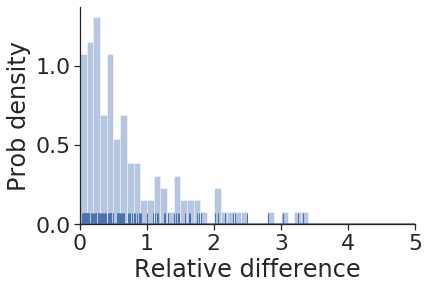

In [6]:
sns.distplot(np.array(cell_shape)**2, hist=True, rug=True, bins=np.arange(0, 10, 0.1))
plt.ylabel('Prob density')
plt.xlabel('Relative difference')
plt.xlim([0, 5])
sns.despine()
plt.show()

## Single cells

In [7]:
k_spk = gaussKernel(sigma=1)
k_sub = gaussKernel(sigma=11)

t_label = np.arange(-t_pre, t_post)/300
c_list = ['k', 'r', 'b']
labels = ['CL', 'Swim-only', 'Visual-only']
sub_ave_before = []
spk_ave_before = []
sub_ave_after = []
spk_ave_after = []
fish_id = []

valid_ind = np.zeros(len(dat_xls_file)).astype('bool')
cell_before = []
cell_after = []
diff_act = []
plot_ = False

for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    if not ablation_pair:
        continue
    folder = row['folder']
    fish = row['fish'][:-26]
    
    ##### valid cell
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_valid_cell.npz')
    valid_cell = np.ones(_['valid_cell'].shape).astype('bool')
    
    ##### before
    _ = sovo_act(folder, fish+'before-swimonly_visualonly')
    if _ is None:
        continue

    sub_ave_before.append(np.array(_[0])[valid_cell])
    spk_ave_before.append(np.array(_[1])[valid_cell])
    fish_id.append(np.array(_[2])[valid_cell])
    
    ##### after
    _ = sovo_act(folder, fish+'after-swimonly_visualonly')
    sub_ave_after.append(np.array(_[0])[valid_cell])
    spk_ave_after.append(np.array(_[1])[valid_cell])

In [8]:
sub_ave_before = np.concatenate(sub_ave_before)
spk_ave_before = np.concatenate(spk_ave_before)
sub_ave_after = np.concatenate(sub_ave_after)
spk_ave_after = np.concatenate(spk_ave_after)
fish_id = np.concatenate(fish_id)
print(f'number of cells {sub_ave_before.shape[0]}')

number of cells 44


In [9]:
print(np.unique(np.array(fish_id)))

['05162019Fish1' '05232019Fish5']


In [10]:
sub_ave = sub_ave_before
spk_ave = spk_ave_before
inh_sub = sub_ave[:, 0, :]
_, p_inh_sub = ttest_1samp(inh_sub, 0, axis=-1)
max_sub = inh_sub.max(axis=-1)
min_sub = inh_sub.min(axis=-1)
min_sub_ind = np.argmin(inh_sub, axis=-1)
valid_cell = (np.abs(min_sub)>1.5*np.abs(max_sub)) & (min_sub<0) & (min_sub_ind<t_pre+100) & (p_inh_sub<0.01)

inh_spk_ = spk_ave[:, 0, :]
valid_spk = inh_spk_[:, t_pre:t_pre+100].mean(axis=-1)<inh_spk_[:, t_pre+150:t_pre+300].mean(axis=-1)
valid_spk_ = inh_spk_.max(axis=-1)>0.5
valid_cell = valid_cell & valid_spk & valid_spk_
print(valid_cell.sum())
print(np.unique(np.array(fish_id)[valid_cell]))
print(np.unique(np.array(fish_id)[valid_cell]).shape)

3
['05162019Fish1']
(1,)


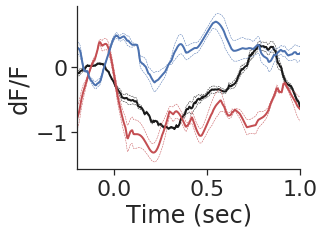

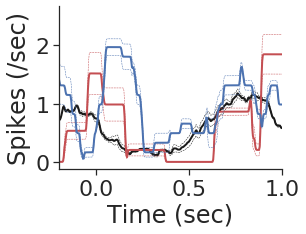

In [11]:
plt.figure(figsize=(4, 3))
for n in range(3):
    ave_ = sub_ave[:, n, :]/np.abs(min_sub[:, np.newaxis])
    std_ = sem(ave_[valid_cell], axis=0, nan_policy='omit')/2
    valid_cell_ = ave_[valid_cell].std()
    mean_ = np.mean(ave_[valid_cell], axis=0)
    plt.plot(t_label, mean_, f'-{c_list[n]}', lw=2)
    plt.plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
    plt.plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
    plt.xlim([-0.2, 1])
    plt.xlabel('Time (sec)')
    plt.ylabel('dF/F')
    sns.despine()
plt.show()

plt.figure(figsize=(4, 3))
for n in range(3):
    ave_ = spk_ave[:, n, :]
    mean_ = np.mean(ave_[valid_cell], axis=0)
    std_ = sem(ave_[valid_cell], axis=0, nan_policy='omit')/2
    plt.plot(t_label, mean_, f'-{c_list[n]}', lw=2)
    plt.plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
    plt.plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
    plt.xlim([-0.2, 1])
    plt.xlabel('Time (sec)')
    plt.ylabel('Spikes (/sec)')
    sns.despine()
plt.show()

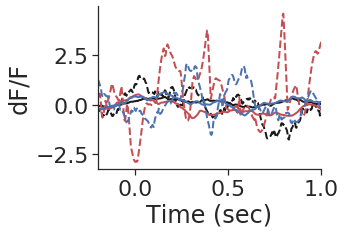

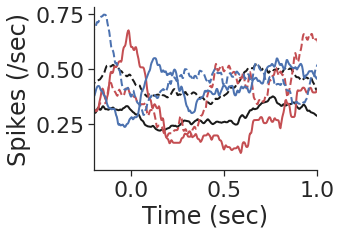

In [16]:
valid_cell = np.ones(sub_ave.shape[0]).astype('bool')
cb_list = ['k', 'r', 'b']
# ca_list = ['g', 'm', 'y']
ca_list = cb_list

plt.figure(figsize=(4, 3))
for n in range(3):
    ave_ = sub_ave_before[:, n, :]/np.abs(min_sub[:, np.newaxis])
    std_ = sem(ave_[valid_cell], axis=0, nan_policy='omit')/2
    valid_cell_ = ave_[valid_cell].std()
    mean_ = np.mean(ave_[valid_cell], axis=0)
    plt.plot(t_label, mean_, f'-{cb_list[n]}', lw=2)
#     plt.plot(t_label, mean_-std_, f'--{cb_list[n]}', lw=0.5)
#     plt.plot(t_label, mean_+std_, f'--{cb_list[n]}', lw=0.5)

    ave_ = sub_ave_after[:, n, :]/np.abs(min_sub[:, np.newaxis])
    std_ = sem(ave_[valid_cell], axis=0, nan_policy='omit')/2
    valid_cell_ = ave_[valid_cell].std()
    mean_ = np.mean(ave_[valid_cell], axis=0)
    plt.plot(t_label, mean_, f'--{ca_list[n]}', lw=2)
#     plt.plot(t_label, mean_-std_, f'--{ca_list[n]}', lw=0.5)
#     plt.plot(t_label, mean_+std_, f'--{ca_list[n]}', lw=0.5)
    plt.xlim([-0.2, 1])
    plt.xlabel('Time (sec)')
    plt.ylabel('dF/F')
    sns.despine()
plt.show()

plt.figure(figsize=(4, 3))
for n in range(3):
    ave_ = spk_ave_before[:, n, :]
    mean_ = np.mean(ave_[valid_cell], axis=0)
    std_ = sem(ave_[valid_cell], axis=0, nan_policy='omit')/2
    plt.plot(t_label, mean_, f'-{cb_list[n]}', lw=2)
#     plt.plot(t_label, mean_-std_, f'--{cb_list[n]}', lw=0.5)
#     plt.plot(t_label, mean_+std_, f'--{cb_list[n]}', lw=0.5)
    
    ave_ = spk_ave_after[:, n, :]
    mean_ = np.mean(ave_[valid_cell], axis=0)
    std_ = sem(ave_[valid_cell], axis=0, nan_policy='omit')/2
    plt.plot(t_label, mean_, f'--{ca_list[n]}', lw=2)
#     plt.plot(t_label, mean_-std_, f'--{ca_list[n]}', lw=0.5)
#     plt.plot(t_label, mean_+std_, f'--{ca_list[n]}', lw=0.5)
    plt.xlim([-0.2, 1])
    plt.xlabel('Time (sec)')
    plt.ylabel('Spikes (/sec)')
    sns.despine()
plt.show()